In [1]:
%run "../common.ipynb"

In [30]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)
display(y_score[0:10])

array([[-0.76, -0.36,  0.12],
       [-0.2 , -0.63, -0.17],
       [ 0.12, -0.8 , -0.32],
       [-0.91, -0.12,  0.02],
       [-0.01, -0.28, -0.72],
       [-0.61, -0.35, -0.06],
       [ 0.02, -0.25, -0.79],
       [-0.61,  0.18, -0.57],
       [-0.38, -0.24, -0.39],
       [-0.47, -0.26, -0.28]])

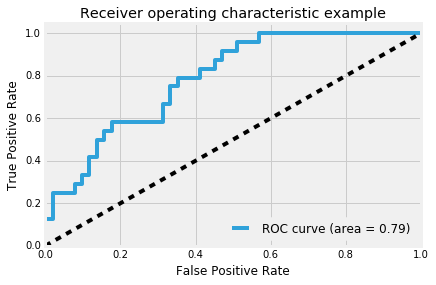

In [36]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

##############################################################################
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

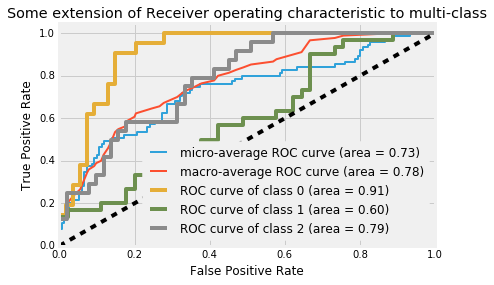

In [37]:
##############################################################################
# Plot ROC curves for the multiclass problem

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [20]:
import sys
import os
from operator import itemgetter
import matplotlib.pyplot as plt


def main(argv=[__name__]):

    afname = sys.argv[1]
    sfname = sys.argv[2]
    ofname = sys.argv[3]

    actives = LoadActives(afname)
    print("Loaded %d actives from %s" % (len(actives), afname))

    # read molecule id - score pairs

    label, scores = LoadScores(sfname)
    print("Loaded %d %s scores from %s" % (len(scores), label, sfname))

    # sort scores by ascending order
    sortedscores = sorted(scores, key=itemgetter(1))

    print("Plotting ROC Curve ...")
    color = "#008000"  # dark green
    DepictROCCurve(actives, sortedscores, label, color, ofname)


def LoadActives(fname):

    actives = []
    for line in open(fname, 'r').readlines():
        id = line.strip()
        actives.append(id)

    return actives


def LoadScores(fname):

    sfile = open(fname, 'r')
    label = sfile.readline()
    label = label.strip()

    scores = []
    for line in sfile.readlines():
        id, score = line.strip().split()
        scores.append((id, float(score)))

    return label, scores


def GetRates(actives, scores):

    tpr = [0.0]  # true positive rate
    fpr = [0.0]  # false positive rate
    nractives = len(actives)
    nrdecoys = len(scores) - len(actives)

    foundactives = 0.0
    founddecoys = 0.0
    for idx, (id, score) in enumerate(scores):
        if id in actives:
            foundactives += 1.0
        else:
            founddecoys += 1.0

        tpr.append(foundactives / float(nractives))
        fpr.append(founddecoys / float(nrdecoys))

    return tpr, fpr


def SetupROCCurvePlot(plt):

    plt.xlabel("FPR", fontsize=14)
    plt.ylabel("TPR", fontsize=14)
    plt.title("ROC Curve", fontsize=14)


def SaveROCCurvePlot(plt, fname, randomline=True):

    if randomline:
        x = [0.0, 1.0]
        plt.plot(x, x, linestyle='dashed', color='red', linewidth=2, label='random')

    plt.xlim(0.0, 1.0)
    plt.ylim(0.0, 1.0)
    plt.legend(fontsize=10, loc='best')
    plt.tight_layout()
    plt.savefig(fname)


def AddROCCurve(plt, actives, scores, color, label):

    tpr, fpr = GetRates(actives, scores)

    plt.plot(fpr, tpr, color=color, linewidth=2, label=label)


def DepictROCCurve(actives, scores, label, color, fname, randomline=True):

    plt.figure(figsize=(4, 4), dpi=80)

    SetupROCCurvePlot(plt)
    AddROCCurve(plt, actives, scores, color, label)
    SaveROCCurvePlot(plt, fname, randomline)


def IsSupportedImageType(ext):
    fig = plt.figure()
    return (ext[1:] in fig.canvas.get_supported_filetypes())

In [126]:
import numpy as np  
import matplotlib.pyplot as plt  
def graph(formula, xmin, xmax, xlabel="", ylabel="", c = None, title= None):  
    x = np.linspace(xmin, xmax, 130)  
    y = eval(formula)
    plt.plot(x, y, c=c, linewidth=1)  
    plt.ylabel(ylabel, fontsize = 15)
    plt.xlabel(xlabel, fontsize = 15)
    plt.title(title or formula , fontsize = 15)
    #plt.suptitle(title or formula , fontsize = 15)
   #plt.show()
    


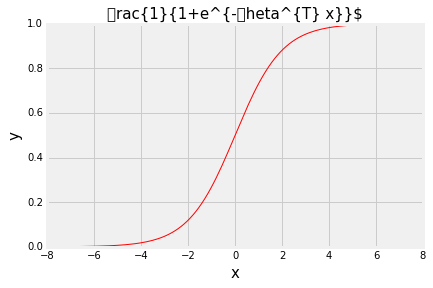

In [129]:
#graph('x**3+2*x-4', range(-10, 11)) 

#graph('1/1+np.exp(-x)', range(-10,10))
graph('1/(1+np.exp(-x))', -8,8, "x", "y", "r", "\frac{1}{1+e^{-\theta^{T} x}}$")
#graph('1/np.exp(-x)', -2,3, "x", "y", "b", "\frac{1}{1+e^{-\theta^{T} x}}$")


In [117]:
formula='1/1+np.exp(-1 * x)'
formula='np.exp(-1 * x)'
x = np.linspace(-2, 2, 20)  
y = eval(formula)
y1= np.exp(-x)

print(x,y,y1)

[-2.   -1.79 -1.58 -1.37 -1.16 -0.95 -0.74 -0.53 -0.32 -0.11  0.11  0.32  0.53  0.74  0.95  1.16  1.37  1.58  1.79  2.  ] [ 7.39  5.99  4.85  3.93  3.18  2.58  2.09  1.69  1.37  1.11  0.9   0.73  0.59  0.48  0.39  0.31  0.25  0.21  0.17  0.14] [ 7.39  5.99  4.85  3.93  3.18  2.58  2.09  1.69  1.37  1.11  0.9   0.73  0.59  0.48  0.39  0.31  0.25  0.21  0.17  0.14]


In [122]:
1/(1+np.exp(2))

0.11920292202211755

In [130]:
from __future__ import unicode_literals
import numpy as np
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
import matplotlib.pyplot as plt

plt.figure(1, figsize=(6, 4))
ax = plt.axes([0.1, 0.1, 0.8, 0.7])
t = np.arange(0.0, 1.0 + 0.01, 0.01)
s = np.cos(2*2*np.pi*t) + 2
plt.plot(t, s)

plt.xlabel(r'\textbf{time (s)}')
plt.ylabel(r'\textit{Velocity (\u00B0/sec)}', fontsize=16)
plt.title(r"\TeX\ is Number \
          $\displaystyle\sum_{n=1}^\infty\frac{-e^{i\pi}}{2^n}$!",
          fontsize=16, color='r')
plt.grid(True)
plt.show()

RuntimeError: LaTeX was not able to process the following string:
b'lp'
Here is the full report generated by LaTeX: 

